# **Yolov3 Tensorflow 2.0**


In [1]:
!git clone https://github.com/zzh8829/yolov3-tf2
%cd yolov3-tf2/
!pip install -r requirements-gpu.txt

Cloning into 'yolov3-tf2'...
remote: Enumerating objects: 387, done.
remote: Total 387 (delta 0), reused 0 (delta 0), pack-reused 387
Receiving objects: 100% (387/387), 4.22 MiB | 9.10 MiB/s, done.
Resolving deltas: 100% (226/226), done.
/content/yolov3-tf2
Obtaining file:///content/yolov3-tf2 (from -r requirements-gpu.txt (line 6))
     |████████████████████████████████| 421.8MB 24kB/s 
     |████████████████████████████████| 28.7MB 110kB/s 
     |████████████████████████████████| 3.9MB 49.3MB/s 
     |████████████████████████████████| 51kB 8.4MB/s 
     |████████████████████████████████| 450kB 48.9MB/s 
  Created wheel for gast: filename=gast-0.2.2-cp36-none-any.whl size=7542 sha256=7ae92c51237602107790632ede43709fbfddaafc237763282c380eff3ff33e91
  Stored in directory: /root/.cache/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
Successfully built gast
ERROR: tensorflow 2.3.0 has requirement gast==0.3.3, but you'll have gast 0.2.2 which is incompatible.
ERROR: 

In [2]:
%cd yolov3-tf2/
!ls

[Errno 2] No such file or directory: 'yolov3-tf2/'
/content/yolov3-tf2
checkpoints	 data		  README.md		train.py
colab_gpu.ipynb  detect.py	  requirements-gpu.txt	yolov3_tf2
conda-cpu.yml	 detect_video.py  requirements.txt	yolov3_tf2.egg-info
conda-gpu.yml	 docs		  setup.py
convert.py	 LICENSE	  tools


In [3]:
import tensorflow as tf
tf.__version__

'2.1.0'

In [4]:
!wget https://pjreddie.com/media/files/yolov3.weights -O data/yolov3.weights
!python convert.py

--2020-08-31 18:35:00--  https://pjreddie.com/media/files/yolov3.weights
Resolving pjreddie.com (pjreddie.com)... 128.208.4.108
Connecting to pjreddie.com (pjreddie.com)|128.208.4.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 248007048 (237M) [application/octet-stream]
Saving to: ‘data/yolov3.weights’

data/yolov3.weights 100%[===================>] 236.52M   349KB/s    in 13m 37s 

2020-08-31 18:48:37 (297 KB/s) - ‘data/yolov3.weights’ saved [248007048/248007048]

2020-08-31 18:48:39.062920: W tensorflow/stream_executor/platform/default/dso_loader.cc:55] Could not load dynamic library 'libnvinfer.so.6'; dlerror: libnvinfer.so.6: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib64-nvidia
2020-08-31 18:48:39.063024: W tensorflow/stream_executor/platform/default/dso_loader.cc:55] Could not load dynamic library 'libnvinfer_plugin.so.6'; dlerror: libnvinfer_plugin.so.6: cannot open shared object file: No such file or directo

In [5]:
# import relevant Libraries.
import sys
from absl import app, logging, flags
from absl.flags import FLAGS
import time
import cv2
import numpy as np
import tensorflow as tf
from yolov3_tf2.models import (YoloV3, YoloV3Tiny)
from yolov3_tf2.dataset import transform_images, load_tfrecord_dataset
from yolov3_tf2.utils import draw_outputs

In [6]:
flags.DEFINE_string('classes', './data/coco.names', 'path to classes file')
flags.DEFINE_string('weights', './checkpoints/yolov3.tf',
                    'path to weights file')
flags.DEFINE_boolean('tiny', False, 'yolov3 or yolov3-tiny')
flags.DEFINE_integer('size', 416, 'resize images to')
flags.DEFINE_string('image', './data/girl.png', 'path to input image')
flags.DEFINE_string('tfrecord', None, 'tfrecord instead of image')
flags.DEFINE_string('output', './output.jpg', 'path to output image')
flags.DEFINE_integer('num_classes', 80, 'number of classes in the model')

app._run_init(['yolov3'], app.parse_flags_with_usage)

physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

# **Getting the CarConnection Data**


In [7]:
!pip install pyunpack
!pip install patool

     |████████████████████████████████| 81kB 3.7MB/s 


In [8]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pathlib
import random as rn
import patoolib
from pyunpack import Archive
import pickle
import datetime
from glob import glob
from PIL import Image

In [9]:
os.chdir('/content/')
path = os.getcwd()
direc_train = "train"
os.mkdir(os.path.join(path,direc_train))

In [10]:
# Extracting Train
patoolib.extract_archive("/content/drive/My Drive/Experiments_CarConnection/thecarconnectionpicturedataset.rar", outdir="/content/train")

patool: Extracting /content/drive/My Drive/Experiments_CarConnection/thecarconnectionpicturedataset.rar ...
patool: running /usr/bin/unrar x -- "/content/drive/My Drive/Experiments_CarConnection/thecarconnectionpicturedataset.rar"
patool:     with cwd='/content/train'
patool: ... /content/drive/My Drive/Experiments_CarConnection/thecarconnectionpicturedataset.rar extracted to `/content/train'.


'/content/train'

In [11]:
train_path = "/content/train"

data_root_train = pathlib.Path(train_path)

print(data_root_train)

/content/train


In [12]:
len(list(data_root_train.iterdir()))

64467

In [13]:
import random
all_image_paths_train = list(data_root_train.glob('*.jpg'))

all_image_paths_train = [str(path) for path in all_image_paths_train]

In [14]:
image_count_train = len(all_image_paths_train)
image_count_train

64467

# **Performing Object Detection to Detect Cars with 0.99% Accuracy.**


In [15]:
%cd yolov3-tf2/

/content/yolov3-tf2


In [16]:
if FLAGS.tiny:
    yolo = YoloV3Tiny(classes=FLAGS.num_classes)
else:
    yolo = YoloV3(classes=FLAGS.num_classes)

yolo.load_weights(FLAGS.weights).expect_partial()
logging.info('weights loaded')

class_names = [c.strip() for c in open(FLAGS.classes).readlines()]
logging.info('classes loaded')

I0831 18:57:52.476508 139880189085568 <ipython-input-16-e395da3cb6f1>:7] weights loaded
I0831 18:57:52.479069 139880189085568 <ipython-input-16-e395da3cb6f1>:10] classes loaded


In [18]:
FLAGS.image = all_image_paths_train[0]

img_raw = tf.image.decode_image(open(FLAGS.image, 'rb').read(), channels=3)
img = tf.expand_dims(img_raw, 0)
img = transform_images(img, FLAGS.size)

boxes, scores, classes, nums = yolo(img)

In [23]:
boxes[0][0].numpy()

array([0.13106489, 0.29865217, 0.8181683 , 0.7933245 ], dtype=float32)

In [27]:
scores[0][0].numpy()

0.9795768

In [30]:
classes[0][0].numpy()

2.0

In [33]:
nums[0].numpy()

1

In [37]:
all_image_paths_train[0].split('/')[3]

'BMW_2-Series_2015_37_17_240_20_4_69_55_174_23_RWD_4_2_Convertible_fml.jpg'

In [60]:
from tqdm import tqdm
bbox = []
image = []
for i in tqdm(range(len(all_image_paths_train))):

  FLAGS.image = all_image_paths_train[i]

  img_raw = tf.image.decode_image(open(FLAGS.image, 'rb').read(), channels=3)
  img = tf.expand_dims(img_raw, 0)
  img = transform_images(img, FLAGS.size)

  boxes, scores, classes, nums = yolo(img)

  if list(classes[0].numpy()).count(2) == 1 and scores[0][list(classes[0].numpy()).index(2)] > 0.99:
    bbox.append(boxes[0][list(classes[0].numpy()).index(2)].numpy())
    image.append(all_image_paths_train[i].split('/')[3])

I0831 19:08:28.325449 139880189085568 <ipython-input-40-59b50ce2ff32>:9] weights loaded
I0831 19:08:28.327179 139880189085568 <ipython-input-40-59b50ce2ff32>:12] classes loaded
I0831 19:08:28.555861 139880189085568 <ipython-input-40-59b50ce2ff32>:23] time: 0.21659111976623535
I0831 19:08:28.556832 139880189085568 <ipython-input-40-59b50ce2ff32>:25] detections:
I0831 19:08:28.561442 139880189085568 <ipython-input-40-59b50ce2ff32>:29] 	person, 0.999958872795105, [0.14398879 0.26509202 0.5349737  0.7090325 ]
I0831 19:08:28.565415 139880189085568 <ipython-input-40-59b50ce2ff32>:29] 	car, 0.990399181842804, [0.00823897 0.2066519  0.21911968 0.47618052]
I0831 19:08:28.569063 139880189085568 <ipython-input-40-59b50ce2ff32>:29] 	car, 0.9413484334945679, [0.26340938 0.2578757  0.8614297  0.9231986 ]


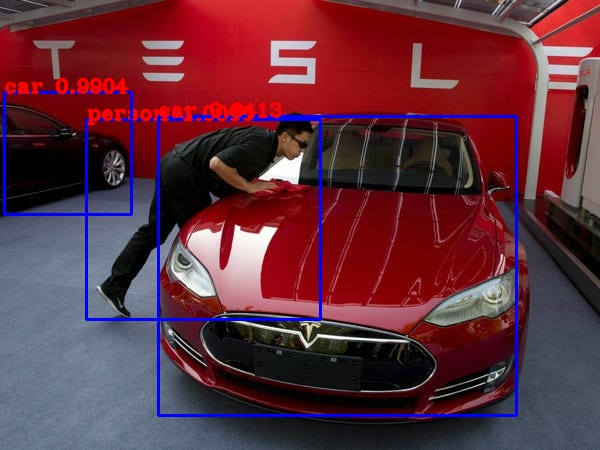

In [40]:
# sample Image detection.
FLAGS.image = '/content/5d308dc19e075556e379ced6.jfif'

if FLAGS.tiny:
    yolo = YoloV3Tiny(classes=FLAGS.num_classes)
else:
    yolo = YoloV3(classes=FLAGS.num_classes)

yolo.load_weights(FLAGS.weights).expect_partial()
logging.info('weights loaded')

class_names = [c.strip() for c in open(FLAGS.classes).readlines()]
logging.info('classes loaded')

img_raw = tf.image.decode_image(
    open(FLAGS.image, 'rb').read(), channels=3)

img = tf.expand_dims(img_raw, 0)
img = transform_images(img, FLAGS.size)

t1 = time.time()
boxes, scores, classes, nums = yolo(img)
t2 = time.time()
logging.info('time: {}'.format(t2 - t1))

logging.info('detections:')
for i in range(nums[0]):
    logging.info('\t{}, {}, {}'.format(class_names[int(classes[0][i])],
                                        np.array(scores[0][i]),
                                        np.array(boxes[0][i])))
    
img = cv2.cvtColor(img_raw.numpy(), cv2.COLOR_RGB2BGR)
img = draw_outputs(img, (boxes, scores, classes, nums), class_names)


from IPython.display import Image, display
display(Image(data=bytes(cv2.imencode('.jpg', img)[1]), width=800))